In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm.notebook import tqdm, trange
import torch
import autograd.numpy as np
import autograd.scipy.stats as stats
import scipy.optimize as optimize
from autograd.scipy.linalg import logm
from autograd import grad, jacobian, hessian
import numpy
import scipy
import pandas as pd
import ipywidgets as widgets
import time
from sklearn import linear_model

# Misc. functions

In [3]:
def decode_q_params(encoded_q):
        shape = len(encoded_q)
        mean_shape = 3
        A_shape = (int(np.sqrt(shape - mean_shape)), int(np.sqrt(shape - mean_shape)))
        mean = encoded_q[0:mean_shape]
        A = encoded_q[mean_shape:shape].reshape(A_shape)
        return mean, A
def encode_q_params(q_params):
    mean, A = q_params
    return np.array(list(mean) + list(A.flatten()))

def decode_d(encoded_d, dim=2):
    return encoded_d.reshape(int(len(encoded_d)/dim), dim)
def encode_d(d):
    return d.flatten()

def augment_d(d):
    return np.concatenate((d.T, [np.ones(len(d))]), axis=0).T

In [4]:
def optimizer(x0, gradient, callback=lambda x, g: True, rate=1, decay=0.5, iters=1e1, label=None, leave=True, thres=0.1):
    x = x0
    for i in tqdm(range(int(iters)), desc=label, leave=leave):
        r = rate * 1/(10+i*decay)
        g = gradient(x)
        x = -g * r + x
        if not callback(x, g):
            break
    return x

In [5]:
def mutual_information(d, covariance_prior, dim=2): # From week 2
    var_y = noise * np.eye(d.shape[0])
    cov_posterior = covariance_prior - covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ d @ covariance_prior
    val = 0.5 * np.log(np.linalg.det(2*np.pi*np.e*cov_posterior)) - 0.5 * np.log(np.linalg.det(2*np.pi*np.e*covariance_prior))
    return val

In [6]:
def stable_multivariate_gaussian_logpdf(x, mu, cov):
    n = cov.shape[-1]
    x_mu = x - mu
    try:
        _, log_det = np.linalg.slogdet(cov)
        cov_inv = np.linalg.inv(cov)
        prod = np.einsum('...i, ...ij, ...j->...', x_mu, cov_inv, x_mu) # todo: find a way to make this understandable
        log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + prod)
    except np.linalg.LinAlgError:
        cov_modified = cov + np.eye(n) * 1e-8
        _, log_det = np.linalg.slogdet(cov_modified)
        cov_inv = np.linalg.inv(cov_modified)
        prod = np.einsum('...i, ...ij, ...j->...', x_mu, cov_inv, x_mu)
        log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + prod)
    return log_prob

In [7]:
def KLD(mean_q, A_q, mean_p, A_p):
    sigma_q = (A_q @ A_q.T)
    sigma_p = (A_p @ A_p.T)
    bar_sigma_q = np.linalg.norm(sigma_q)
    bar_sigma_p = np.linalg.norm(sigma_p)
    k = len(mean_q)
    return 0.5 * (np.trace(np.linalg.inv(sigma_p) @ sigma_q) + (mean_p - mean_q).T @ np.linalg.inv(sigma_p) @ (mean_p - mean_q) - k + np.log(bar_sigma_p/bar_sigma_q))
def log_likelihood_opt(y, theta, d):
    d_offset = np.concatenate((d.T, np.ones((1, len(d)))), axis=0).T
    likelihood_cov = np.mean(np.square(y - np.matmul(theta.T, d_offset.T)), axis=1)[:, np.newaxis, np.newaxis] * np.eye(len(d))[np.newaxis, ...]
    likelihood_mean = np.matmul(theta.T, d_offset.T)
    log_likelihoods = stable_multivariate_gaussian_logpdf(y, likelihood_mean, likelihood_cov)
    return log_likelihoods
def elbo_optimized(q_params, d, y_i, shape=3, batch_size = 500):
    mean, A = q_params
    sample_values = np.random.multivariate_normal(np.zeros(3), np.eye(3), size=batch_size)
    theta = np.expand_dims(mean, axis=1) + A @ sample_values.T
    lik = log_likelihood_opt(y_i, theta, d)
    mean_term = (1/batch_size) * np.sum(lik)
    kld_term = KLD(mean, A, mean_prior, A_prior)
    
    return mean_term - kld_term
def log_posterior(theta_i, q_params):
    mean, A = q_params
    return stable_multivariate_gaussian_logpdf(theta_i, mean, A @ A.T)

# The Log Posterior Grad
This does not work yet - my testing indicates that it is the indirect gradient that is somehow wrong.
The result of the log-posterior gradient is off by atleast a factor of 10 compared to the one computed by autograd, so I don't think it is just a small approximation error that is negligable.

In [8]:
def log_posterior_grad(theta_i, y_i, d, q_params):
    batch_size=500
    
    def training_hessian_inner(q_params):
        return elbo_optimized(decode_q_params(q_params), d, y_i, batch_size=batch_size)
    
    def training_mixed_partials_inner(encoded_q):
        def deep_inner(d):
            return elbo_optimized(
                    decode_q_params(encoded_q), 
                    decode_d(d), 
                    y_i, 
                    batch_size=batch_size
                )
        return encode_d(
            grad(
                deep_inner
            )(encode_d(d))
        )
    
    def inner_grad_q(encoded_q_params):
        mean, A = decode_q_params(encoded_q_params)
        return stable_multivariate_gaussian_logpdf(theta_i, mean, A @ A.T)
    
    training_hessian = hessian(training_hessian_inner)

    training_mixed_partials = jacobian(training_mixed_partials_inner)
    
    encoded_q = encode_q_params(q_params)
    latest_hessian = training_hessian(encoded_q)
    
    grad_log_q = grad(inner_grad_q)(encoded_q).reshape(1, len(encoded_q)) # 1 x 12
    
    # NOTE: This is an alternative to the indirect gradient - this relies on being
    # able to find the analytical optimal q
    alt_grad = jacobian(lambda d: encode_q_params(analytical_optimal_q(decode_d(d), y_i)))(encode_d(d))
    return (grad_log_q @ alt_grad)[0]
    
    # This is the remaining code that is supposed to calculate the indirect gradient
    for i in range(20):
        if np.linalg.det(latest_hessian) != 0:
            evaluated_partials = training_mixed_partials(encoded_q)
            inv = np.linalg.inv(latest_hessian)
            return (grad_log_q @ (- inv @ evaluated_partials.T))[0]
        latest_hessian = latest_hessian + 1e-8 * np.eye(latest_hessian.shape[0])
    raise ValueError("Was not able to invert hessian")

# Inner optimization loop
This function returns the parameters for q that approximates the log-posterior as closely as possible

In [9]:
# Get mean, A for log q to approximate log_posterior
def optimal_q(d, y_i, rate=0.1, decay=0.5, iters=100):
    thetas = []
    def objective_f(encoded_q):
        q_params = decode_q_params(encoded_q)
        return - elbo_optimized(q_params, d, y_i)
    def callback(qi, g):
        mean, A = decode_q_params(qi)
        thetas.append(mean)
        elbos.append(-objective_f(qi))
        g_norms.append(np.linalg.norm(g))
        return True
    results = optimizer(
        encode_q_params(
            (mean_prior, A_prior)
        ), 
        grad(objective_f), 
        callback=callback, 
        label="Optimizing for q", 
        leave=False, 
        rate=rate,
        iters=iters, 
        thres=0.1,
        decay=decay
    )
    return decode_q_params(results), thetas

def analytical_optimal_q(d, y_i):
    d = np.concatenate((d, np.array([np.ones(d.shape[0])]).T), axis=1)
    var_y = np.var(y_i) * np.eye(len(y_i))
    covariance_prior = A_prior @ A_prior.T
    mean_theta = covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ y_i
    #print(covariance_prior @ X.T @ np.linalg.inv(var_y + X @ covariance_prior @ X.T) @ y)
    cov_theta = covariance_prior - covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ d @ covariance_prior
    #print(mean_theta, cov_theta)
    return mean_theta, np.linalg.cholesky(cov_theta)

# The MI gradient
This loop return the gradient as we've calculated in the theory-part of week 4. It has been modified to not use the variational distribution, but instead directly use the actual log-posterior for now.

In [29]:
noise = 0.2
def MI_grad(d):
    d_offset = np.concatenate((d, np.array([np.ones(d.shape[0])]).T), axis=1)
    size = d.shape[0]
    N = 5
    theta_samples = np.random.multivariate_normal(mean_prior, A_prior @ A_prior, size=N)
    sample_results = []
    #elbos = []
    optimal_qs = []
    for i in tqdm(range(N), desc="Sampling over theta", leave=False):
        theta_i = theta_samples[i]
        z_i = np.random.multivariate_normal(np.zeros(size), noise * np.eye(size))
        d_offset = augment_d(d)
        y_i = theta_i @ d_offset.T + z_i
        #q_params, _ = optimal_q(d, y_i, rate=30, decay=0.9, iters=50)
        q_params = analytical_optimal_q(d, y_i) # NOTE: Uses analytical solution for now
        optimal_qs.append(q_params)
        def log_posterior_grad_alt(theta_i, y_i, d, q_params): # This can replace log_posterior_grad for debugging
            return -grad(
              lambda xs_: log_posterior(
                  theta_i, 
                  analytical_optimal_q(decode_d(xs_), y_i)
                  )
              )(encode_d(d))
        result = log_posterior_grad(q_params[0], y_i, d, q_params) * (log_posterior(theta_i, q_params) + 1)
        sample_results.append(result)
    optimal_params.append(optimal_qs)
    return decode_d(np.mean(np.array(sample_results), axis=0), dim=2)

# Run this cell to find optimal d
As you can see, this takes a while - even when it uses the analytical solution.
I recommend running it for atleast 10-20 iterations of the outer loop

In [31]:
#d0 = np.array([[1,1], [2,2], [3,9]])
d0 = np.random.randn(10,2)
#A_prior = np.array([[5, -2, 1],
#              [-2, 4, -1],
#              [1, -1, 3]])
A_prior = np.eye(3)
mean_prior = np.array([0, 0, 0])
optimal_params = []
data_sets = []
dis = []
g_norms = []
elbos = []
def callback(di, g):
    if len(dis) > 0:
        print("New MI iteration. MI=%s. g=%s" % (mutual_information(augment_d(di), A_prior @ A_prior.T), np.linalg.norm(g)))
    dis.append(di)
    return True
optimizer(d0, MI_grad, callback=callback, label="Optimizing for d", iters=500, rate=0.1, decay=0.1)

Optimizing for d:   0%|          | 0/500 [00:00<?, ?it/s]

Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.992465254332861. g=0.5588991207631666


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.987472947703329. g=0.739315196655334


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.989598135947425. g=0.3207147126303479


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.987368321533417. g=0.3363023680198078


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.986744643628086. g=0.09751129848335852


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.98236019389743. g=0.6728821170669597


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.979147563637767. g=0.49702661339910936


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.976124367296462. g=0.47115795346772404


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.976078887729049. g=0.022760194255883312


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.976628230868923. g=0.09178916447210429


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.968677045062364. g=1.2699387884443256


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.9665539597843225. g=0.3415908206389588


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.96236267173914. g=0.6793141490461926


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.959880281508015. g=0.4049423700159503


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.958608442408119. g=0.20915793061016594


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.954823936862594. g=0.6267626163329013


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.9502309458983484. g=0.7656873124366782


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.947537954331558. g=0.4518124751502925


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.94432871355013. g=0.5422681336497562


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.945132101252633. g=0.13701068048948492


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.9434305938294045. g=0.2920612515854831


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.939169260904563. g=0.7364835116621206


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.933932079801309. g=0.9105029006523199


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.933911985621961. g=0.021366117667546577


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.9316377151483675. g=0.40097310535585423


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.9286363188350695. g=0.5329982267317072


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.930262942059003. g=0.2953830076023469


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.923940501600396. g=1.1383605091770685


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.921826316275791. g=0.3829514344814858


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.918052282867588. g=0.6878564997516083


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.916294251373562. g=0.32310948563895453


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.908933558702169. g=1.3566722012397574


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.903000225940814. g=1.098489846715774


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.901060187780545. g=0.36126214917640737


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.8978530174359065. g=0.6008348769510672


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.894415431606813. g=0.6475355261467107


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.892876600308132. g=0.2915930224472212


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.8908081362561635. g=0.3946771624284084


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.8889092627794. g=0.3647732017399627


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.887244178737532. g=0.32163398010803995


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.885839937018758. g=0.2728928681609018


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.886525656662796. g=0.1363280334652845


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.884388521855181. g=0.4211577470288934


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.88247291936112. g=0.38001735108371687


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.881104955317429. g=0.2728306776178193


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.878121405068471. g=0.5986496463017917


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.87722549015294. g=0.18090250792575263


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.876689013933044. g=0.121183240659159


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.87720080314376. g=0.1323128387063419


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.876056056163118. g=0.2356504869593839


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.873619374439892. g=0.5041717372629339


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.871024761731606. g=0.5398193602115969


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.8712251333276475. g=0.05376839423410414


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.866707139996334. g=0.9505348525891942


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.865153992043496. g=0.3298867030804756


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.865511142531325. g=0.08014896003952493


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.863523643636874. g=0.4257741718675387


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.861089024727048. g=0.5238662984009071


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.858264655704922. g=0.6111398288045903


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.8556394689082385. g=0.570787950476626


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.853926182113744. g=0.3744081155567695


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.852709022609753. g=0.2681303010950889


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.8517838046510615. g=0.20432180888808404


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.848132737928914. g=0.8107623206801486


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.845984133905134. g=0.4791665761788763


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.84530251427487. g=0.1531412038755795


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.83911790246761. g=1.392370892696283


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.8382175031846115. g=0.20507943140199955


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.834630635541049. g=0.8148975186366417


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.832767268848331. g=0.42706377344923396


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.830618860759484. g=0.49323719505652464


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.829205408537461. g=0.32630994327229357


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.826708438864568. g=0.5792295756786553


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.823531222915256. g=0.7392400432877033


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.822323571138313. g=0.28290600451341635


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.81960163044297. g=0.639204437874912


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.8188502534711555. g=0.17762546245984803


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.817770331794799. g=0.25660899515851077


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.81634000094969. g=0.3410816948338396


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.813935155305503. g=0.5761194812978574


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.8113571411746685. g=0.6203512928220997


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.8098144129195655. g=0.3850432646362812


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.808410800174565. g=0.3410868912460382


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.808413862835719. g=0.010727622596114619


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.806530400538908. g=0.4620132134759341


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.807893506408986. g=0.3363408640377906


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.804702830586953. g=0.7902764079276733


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.80280610580456. g=0.4715489611837981


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.802700088522758. g=0.026939041681758005


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.800494250974329. g=0.5536323188055712


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.795609867405968. g=1.2302175671988442


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.796039415405358. g=0.10904351861221175


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.7932639207157655. g=0.7054175456026366


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.793288966410996. g=0.06376609805369834


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.792608459217837. g=0.1857205746938687


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.790922388379834. g=0.43440117982032517


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.7926633152850595. g=0.46006546586535757


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.789531762421496. g=0.8148095651482162


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.787558849119206. g=0.5154758313037733


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.785608750659058. g=0.5113648654403665


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.782619903688065. g=0.7868563213140217


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.783817574781603. g=0.3268351364518453


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.781071368857392. g=0.7296747299445931


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.779645329229755. g=0.3803118323946807


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.777238911648203. g=0.6441686938573089


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.775689192882169. g=0.4168189832530752


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.7749777018013715. g=0.19242539611113965


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.774727366487225. g=0.06934482354404652


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.772702089459852. g=0.5517565378005705


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.771315617681724. g=0.3789507130949923


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.770111489812406. g=0.33050388882147647


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.768668069371087. g=0.3992323453833845


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.766366602040737. g=0.6368738221627911


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.767132491102134. g=0.2127862288737473


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.76513618777747. g=0.5572342580445081


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.763008253866348. g=0.5961916220655663


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.7594708268802535. g=0.9939874743818329


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.757278940105877. g=0.6179643038156613


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.755674219451431. g=0.4538952873052811


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.755313325133734. g=0.10280430994157774


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.754052789804097. g=0.3595925352991974


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.752722118678576. g=0.38156552282252093


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.750868879549406. g=0.5325781590804184


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.748884446994916. g=0.5723293304266307


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.745009035429552. g=1.121195372460452


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.74340688383418. g=0.4647944400024804


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.739828760216505. g=1.0412970378846007


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.737917233686235. g=0.5582173652686012


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.736377213353036. g=0.4515734153923184


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.735606508828686. g=0.22665904020679056


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.7343044359597295. g=0.38434818519771563


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.732087877316487. g=0.6565704239401542


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.7296810298654615. g=0.715260829773128


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.72492669750077. g=1.416097218894059


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.7217715676314285. g=0.9419430131045804


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.721213516228574. g=0.16721269516592455


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.7204227413917925. g=0.23792499158038738


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.718328580513128. g=0.6319414861223187


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.716660290506111. g=0.5054861232128787


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.714989764939964. g=0.5075629001950942


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.715608757472465. g=0.20145099200296457


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.713836493731835. g=0.542499042231699


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.710143598673613. g=1.133698543786863


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.707813062426914. g=0.7173582457870273


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.707182605855883. g=0.19480818670202055


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.70423812584825. g=0.912178558293978


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.703738795729772. g=0.15572689534058298


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.7018140859061965. g=0.6009857470143517


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.700451187330189. g=0.4266129309997434


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.698883864098502. g=0.49194549236789586


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.6976852153874695. g=0.37844062078567897


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.696751968953658. g=0.29513194955465816


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.694010325191064. g=0.8694178624563558


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.6929434454446595. g=0.3396099509793464


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.692526456706906. g=0.13396444744874966


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.68964607311843. g=0.9219229578898389


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.688976019167028. g=0.21670430802180593


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.688045161186995. g=0.3003670439052316


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.6861546037812. g=0.6109073420414606


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.685905594015928. g=0.1047746472890546


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.683873631865529. g=0.6609429668076533


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.684349912916883. g=0.16443675306472932


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.681775709030852. g=0.8431367191967237


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.678865468455912. g=0.9558191032251477


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.676786241014474. g=0.6847096746432438


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.674518488999404. g=0.7486680247651433


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.671951651315724. g=0.8493868598982899


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.67046130658002. g=0.49464156361541


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.667544966834807. g=0.9700600038960333


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.666426577482109. g=0.37329429708725204


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.664856110086702. g=0.525545313239384


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.661234364355851. g=1.214389454019942


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.659322285125131. g=0.6427473627454804


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.65764051836726. g=0.5667925756324622


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.656460270489589. g=0.3994574421257415


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.655906728120067. g=0.187693540392625


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.655078338275806. g=0.2818380930268005


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.654956835292004. g=0.04148909211252535


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.653977802431899. g=0.3354749651328673


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.653659348913718. g=0.11205845760389731


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.652922624946537. g=0.26179065187620887


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.652201726620152. g=0.24930230972572578


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.650003589789295. g=0.7624706315269103


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.64869129127857. g=0.4571839890892317


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.647277810634726. g=0.4983606375947571


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.64535069530222. g=0.6738139291611026


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.646013943553325. g=0.23799676035157813


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.645868534204776. g=0.0873252083214764


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.643952123428281. g=0.6769630828399111


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.642131283036118. g=0.6445690751765599


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.639554264959437. g=0.9143433541699509


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.636961663180696. g=0.9227618731512208


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.637234923681504. g=0.09769257858090762


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.635357994974379. g=0.6715116035235154


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.6342289007549855. g=0.40494801662052743


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.6328589046629345. g=0.4927269572334767


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.629512125618858. g=1.2061600960059444


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.6268403859336384. g=0.9646292355036229


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.626396565603428. g=0.16457747797789918


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.626736479839952. g=0.12882403132007766


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.624807378059514. g=0.7026581841554813


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.623918935282899. g=0.3244316669501035


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.624235410952054. g=0.16015739543023993


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.622467992810384. g=0.6493514839901867


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.62274620973223. g=0.11170895606024353


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.6216551020619665. g=0.4034363094086283


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.621253225908528. g=0.15587513990747412


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.620283022650554. g=0.3606955765117636


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.6191510808712755. g=0.422167740190139


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.617975798285771. g=0.43965392254966557


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.617592619975242. g=0.14450155482367133


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.616199553421084. g=0.5236172156306588


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.615075977674451. g=0.4241410861420923


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.614255256586238. g=0.3103831580699822


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.611887743254207. g=0.8969409448544129


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.6103259957878535. g=0.5928115314663417


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.6101215160892774. g=0.0886245492451574


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.610161945793365. g=0.02880135100841935


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.609765333961269. g=0.15296419422647597


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.610686191330851. g=0.35443053096585664


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.610036271402115. g=0.2526633393775759


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.609954901799068. g=0.05001423691914277


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.608200420665499. g=0.6801334371857011


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.60813846697059. g=0.02921583963917238


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.606664174604127. g=0.5744738464402569


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.605876486548217. g=0.30778218880260183


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.604451515888145. g=0.5580749720023874


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.6023556825902086. g=0.8230039460664625


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.601537334822434. g=0.3234713124090807


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.600589516692003. g=0.37382566422550606


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.598082734898861. g=0.9908342739396802


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.596894694612205. g=0.4705929982820871


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.593107220341072. g=1.5028782582034574


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.591012612858185. g=0.832540443835701


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.589245179328257. g=0.7040610788238496


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.588369626085204. g=0.3494783904514957


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.58889883783303. g=0.21187649950714096


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.589305544229536. g=0.16524999490718748


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.588847938428173. g=0.1850087639936181


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.588668591791386. g=0.07245439625814733


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.588211766650664. g=0.18574998780364213


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.585795127763416. g=0.9810059218441475


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.584204645731137. g=0.6468303906686865


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.581938007244159. g=0.924031394380043


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.581074976393305. g=0.3532713092689004


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.579276148393172. g=0.7366023720700743


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.577228413760183. g=0.8401555336019083


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.575266574576697. g=0.8063482508476936


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.573994976770004. g=0.5235003578443898


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.572725082099326. g=0.5242322574390484


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.571146193562532. g=0.6530986121640634


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.5693445924539695. g=0.7470161571890827


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.567888149470875. g=0.6047070130678713


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.566133141826976. g=0.7301688543688498


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.565819871520774. g=0.1331904119909976


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.564982615599245. g=0.3513106260750333


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.564934008611578. g=0.04735855170747393


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.563373813389742. g=0.6564159389011214


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.5626348164854775. g=0.31117497049965664


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.561467028700733. g=0.49308540372683174


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.5605436347273764. g=0.39068262896726436


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.55982489217898. g=0.3047982705556319


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.559617128811343. g=0.08866689500657546


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.559005052055096. g=0.2648881038526266


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.5590893221552795. g=0.03945687084449653


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.558091781719172. g=0.42729350088927526


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.5557848660985805. g=0.9902640166024976


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.553539486799606. g=0.9651184203685442


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.553184178116119. g=0.15723495167754006


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.552030740688282. g=0.4985149583315433


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.550508911254536. g=0.659272905390879


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.549181704173187. g=0.5758368331854107


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.5483168271420285. g=0.3759301597847334


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.547109115913326. g=0.5258307185739713


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.544582275521113. g=1.1019349338490625


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.542726762557658. g=0.8106014186628676


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.541971712436609. g=0.33085715989969006


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.541304438733642. g=0.2927170755053344


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.540448857714199. g=0.3769178972950538


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.539702864001874. g=0.32876967827172815


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.538756391497822. g=0.4182018463692257


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.536267474117627. g=1.101155120971018


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.5350732114775685. g=0.5295607190454397


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.534638003909603. g=0.1946257408899962


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.53337437012942. g=0.562841282872728


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.531947577970328. g=0.6383065128071157


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.532062998821906. g=0.06932033076972628


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.532167358681316. g=0.05065555771740091


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.529893604046738. g=1.021159240764155


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.529245394675392. g=0.2956013782124262


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.527877883883114. g=0.6172044801910086


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.526013732799704. g=0.8419282355761591


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.5260212921658205. g=0.00353495117488454


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.524805683958484. g=0.5517789592056122


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.523905461980046. g=0.4094990651514829


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.520403193622581. g=1.594063956694114


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.518982834376842. g=0.6479743425988246


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.516572262106612. g=1.1004448810413299


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.516185225495786. g=0.17851139046936387


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.515879093998401. g=0.14424567845229802


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.514471101078587. g=0.646835988137494


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.513843832061668. g=0.28963169729407867


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.512503180325788. g=0.6183430422919367


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.511408072913322. g=0.506357519611698


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.51030242199936. g=0.5127916725619825


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.50919642421816. g=0.5130695024084642


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.50766002683978. g=0.7141175248793491


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.506086468350084. g=0.7323851742130085


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.505011408040814. g=0.5014946783005249


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.503450815687607. g=0.7293053792004464


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.502052289496342. g=0.6543866701075819


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.500156043395831. g=0.8888119460484714


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.499137417705664. g=0.47873107169795276


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.49837088764352. g=0.3605824725178466


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.497347488387971. g=0.48297016239988233


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.495446745776378. g=0.8975933267546417


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.495888463501715. g=0.21544719481561342


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.496838112027894. g=0.45225308288295346


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.495262312769986. g=0.7499397701920938


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.493882789308468. g=0.6571040978551211


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.492942204389179. g=0.4491763663736474


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.492875466301802. g=0.031937948614748496


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.491849525322856. g=0.4918115705914434


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.490605510419007. g=0.5976794394874224


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.489252965684339. g=0.6504897652394118


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.488365543210625. g=0.4285544929517366


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.4869960042800665. g=0.6608410469632254


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.488059687074319. g=0.5150671025886056


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.487542861856138. g=0.25056163479264365


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.487519393375818. g=0.012099636265364583


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.485379454678813. g=1.041764712485249


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.482848046369336. g=1.2338122327788337


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.482097903965779. g=0.36698220661927344


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.480282613315213. g=0.8874689962883305


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.4819114141944425. g=0.7986151309212107


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.480845737045105. g=0.5238155846349547


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.479923753270666. g=0.4536785229591702


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.479465440334927. g=0.22981512578720906


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.4772817077739475. g=1.0785527268165553


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.4768575750740975. g=0.2101713169952625


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.474880736158779. g=0.9795288419395102


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.474147854295751. g=0.36526616314113014


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.473320700321452. g=0.4125929732245563


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.473813520714232. g=0.2603125115208551


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.472031081413539. g=0.890100996078944


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.4704761770259624. g=0.7774478601032413


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.4705871807543085. g=0.08420326752292157


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.469105689645561. g=0.7472370536651138


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.468622354982143. g=0.24406126791537958


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.4663206365471675. g=1.1588533664933638


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.464263007049815. g=1.038464243873507


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.464544027702854. g=0.14648749038761844


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.463270467320361. g=0.6443800517241423


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.462827312516572. g=0.22510783455790034


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.462100205383892. g=0.3694870120258003


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.45969380088837. g=1.223745072733814


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.458232744822999. g=0.7440849910021966


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.457021249242455. g=0.6178881378706439


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.455002131128741. g=1.0311071913204195


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.454127318827342. g=0.44792485799525045


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.452378863258236. g=0.8955489536837702


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.45269140370432. g=0.16369635653174391


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.452754001935555. g=0.0595727578128808


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.4511300104201155. g=0.8367981411487062


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.449404201456204. g=0.8903031666710164


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.447730389305115. g=0.8649776931043942


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.446478402945427. g=0.6486633628561493


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.445676774279942. g=0.4159408258214136


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.444763258309697. g=0.4742518178751862


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.4440538460414345. g=0.36885440769538275


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.443167580823097. g=0.4616922264800395


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.443249823730355. g=0.047465191202921676


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.440598925458732. g=1.3854145845442822


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.4390340781491275. g=0.8187726880817736


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.437936679253492. g=0.5750156956303026


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.437268314212454. g=0.35194092664525295


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.435928594099843. g=0.7045413400016637


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.435021580350743. g=0.47782705800154635


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.434045920461144. g=0.5149407768095173


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.435976638026575. g=1.0206702744002811


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.434103148290482. g=0.9924511489778451


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.432913493477442. g=0.6322237805605689


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.43100748434841. g=1.0122792783039403


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.430363348407493. g=0.34323131112579663


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.431101184240216. g=0.3978304006427645


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.429363905341673. g=0.9281660279864155


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.428861695816454. g=0.26859434884074823


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.428133790642484. g=0.38993353899358096


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.426413672479803. g=0.9228982196499569


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.424869856565264. g=0.8297179573996327


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.425371031836367. g=0.2704034423191688


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.425425346730276. g=0.03390564537777728


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.4238430608070205. g=0.8547202704708144


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.422459528889554. g=0.7483627798473117


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.422301170115304. g=0.08850609110831005


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.426341321626499. g=2.195795053415914


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.4262176753803075. g=0.06937701541636516


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.425110258233289. g=0.60473633259077


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.423523008311994. g=0.8683846476217428


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.423554380810697. g=0.019245130857489703


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.423576555595592. g=0.032220758037036425


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.422373935731597. g=0.661015338061139


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.420488234262576. g=1.0376481707462335


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.419805277564509. g=0.37632219460746125


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.418151037695349. g=0.9129941882767704


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.41678729899934. g=0.753750736336265


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.416756018143654. g=0.017674635086525486


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.417574154468889. g=0.4557824671798897


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.416789464599053. g=0.4360535094205115


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.4152586535126375. g=0.8523678249115915


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.414910005752193. g=0.20225623293571202


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.41409810593762. g=0.4535942175577413


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.412719725497817. g=0.771251737210934


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.412513980946263. g=0.11541114031209704


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.412391651235982. g=0.08232264844507657


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.4113201227733425. g=0.6028926758061445


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.409883880667825. g=0.8084531982606372


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.40882875484796. g=0.5944209382594089


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.408327971713334. g=0.28313479662259533


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.407164579974369. g=0.6576357659999955


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.405611092356054. g=0.8797949168115121


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.405874496530412. g=0.1494138474087438


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.405237233115815. g=0.36229706477908


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.403713927112932. g=0.8663345065522893


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.402504217102605. g=0.688639407843699


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.4021661835068615. g=0.1937154991728299


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.402636111123175. g=0.27303888423322176


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.40240201575033. g=0.1370905052061111


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.400851479942053. g=0.8891090772882224


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.39972279212501. g=0.648499731864723


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.399102548218254. g=0.3564775307607224


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.399589463123638. g=0.2809872543359468


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.398755412200495. g=0.4824895136376532


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.398610459992121. g=0.1157192285327503


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.398677182496089. g=0.054498430127283164


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.399071689616624. g=0.23543912044028054


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.39768791614626. g=0.8042702720527337


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.397365923451643. g=0.20224637939711196


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.404188242681136. g=3.98647058988477


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.402294549496484. g=1.1089981163925493


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.401220285516405. g=0.6297558644015344


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.400659784572241. g=0.33113550567425654


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.399726571315794. g=0.5486889646207808


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.398750220005987. g=0.5753065239223596


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.396558273166587. g=1.2921938330009324


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.395632883162846. g=0.5462699039122317


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.3946722517887045. g=0.5676832417719418


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.3930316136291045. g=0.9705140003641683


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.39201300383598. g=0.6032857304203922


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.392031019123057. g=0.021560644595151852


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.390481353827953. g=0.9212566820462951


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.389995128125008. g=0.28951840663924294


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.388357758739635. g=0.9751826000265712


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.386810818145874. g=0.9232821286506507


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.385496264797796. g=0.7846418692878471


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.384402369661265. g=0.6536975743175006


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.385498766244255. g=0.6691279945426359


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.385376382433636. g=0.07482527412122865


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.385218589126511. g=0.09697942957041855


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.384379542737953. g=0.5061469782163549


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.383856209391199. g=0.31550856411730654


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.382968370115759. g=0.5363890494786504


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.381797080331323. g=0.7086362594109358


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.380951116901648. g=0.512591553897712


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.380036177837466. g=0.5550614292529218


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.379005332244157. g=0.6255831239877736


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.379276731465392. g=0.17278728748098118


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.378539763643067. g=0.4504065988046396


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.377471753031821. g=0.6512865950415164


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.375342230369348. g=1.2992721567377308


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.375173774382041. g=0.13400469087933117


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.374841147689256. g=0.20858961178532828


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.37459247896315. g=0.15385710355516888


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.373805652240876. g=0.48290912675721914


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.372829960183497. g=0.6000733487161638


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.372135169698197. g=0.4278671195242314


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.372132117849698. g=0.033889712313515966


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.371136945942017. g=0.6156640747474692


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.371249829881031. g=0.09366089060212761


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.370329096263394. g=0.5724524276747722


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.3699904199338855. g=0.21000292033994747


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.369312786205505. g=0.42107084882277457


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.369314025376276. g=0.014304900437921876


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.370181008368403. g=0.5401777954550017


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.368802067155126. g=0.8606760390056993


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.367839703031581. g=0.6015025521555907


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.366074866703653. g=1.104162803888297


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.366019759905988. g=0.03682495238247603


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.364793535947997. g=0.7690752547279109


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.363667297486908. g=0.7094828968824626


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.363020376468708. g=0.40666134289350053


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.362795968304749. g=0.1429722883126892


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.362756391791228. g=0.050080009121214596


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.361782121887353. g=0.6156769697032057


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.361863459468873. g=0.05552594365887237


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.360365820207474. g=0.9483585717276707


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.358869342321912. g=0.9485855820181048


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.358339124313484. g=0.3374779636952605


Sampling over theta:   0%|          | 0/5 [00:00<?, ?it/s]

New MI iteration. MI=-4.357104196177542. g=0.7858084127642442


array([[-1.56201905,  0.57488613],
       [-0.54797587, -0.45964153],
       [-0.7575967 , -0.1520254 ],
       [-0.90294802,  0.13524739],
       [-0.70556064,  0.32607488],
       [-0.35143444, -0.39587646],
       [ 0.21977055, -0.68419491],
       [-0.09878144,  0.40055099],
       [-0.66048334,  0.55992784],
       [-1.4461089 , -0.03903816]])

# Plots of results

Text(0, 0.5, 'MI')

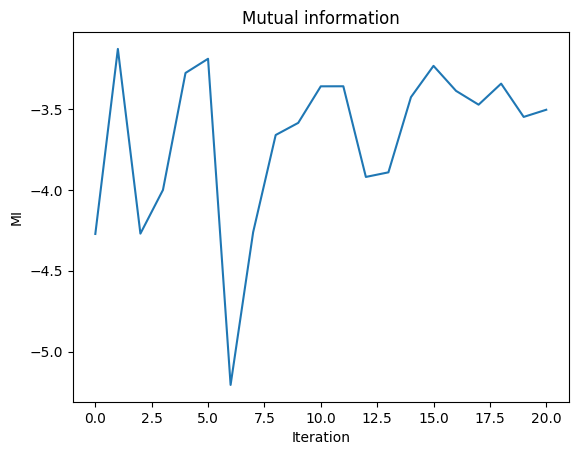

In [17]:
plt.plot(np.arange(0, len(dis)), np.array([mutual_information(np.array([d[:, 0], d[:, 1], np.ones(len(d))]).T, A_prior @ A_prior.T, dim=3) for d in dis]))
plt.title("Mutual information")
plt.xlabel("Iteration")
plt.ylabel("MI")

Text(0.5, 1.0, '$d$ at iteration 20')

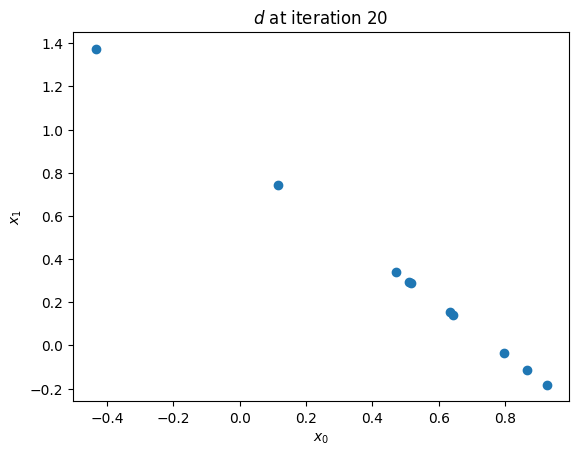

In [24]:
i = 19
di = dis[i]

plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.scatter(di[:, 0], di[:, 1])
plt.title("$d$ at iteration %d" % (i + 1))